In [1]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

# Test of Radiation solver

In [20]:

nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0))
A, absorbtion_rate, stimulated_emission_rate = nlte_solver.processes[1].get_einstein_rates()
i23S = nlte_solver.states.all_names.index("23S")
i23P = nlte_solver.states.all_names.index("23P")

print("A rates ordered correctly:", A[i23S, i23P] > 0 and A[i23P, i23S] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23S, i23P] == 0 and absorbtion_rate[i23P, i23S] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23S, i23P] > 0 and stimulated_emission_rate[i23P, i23S] == 0)
print("g factor correct:", absorbtion_rate[i23P, i23S]/stimulated_emission_rate[i23S, i23P] == 3)

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0))
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0)) # Approaching T->inf
print("High temperature limit correct: ", 0.5 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


In [21]:
states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states)
A, absorbtion_rate, stimulated_emission_rate = nlte_solver.processes[1].get_einstein_rates()
i23P = nlte_solver.states.all_names.index("23P")
i33S = nlte_solver.states.all_names.index("33S")

print("A rates ordered correctly:", A[i23P, i33S] > 0 and A[i33S, i23P] == 0)
print("Absorbtion rates ordered correctly:", absorbtion_rate[i23P, i33S] == 0 and absorbtion_rate[i33S, i23P] > 0)
print("Stimulated rates ordered correctly:", stimulated_emission_rate[i23P, i33S] > 0 and stimulated_emission_rate[i33S, i23P] == 0)
print("g factor correct:", np.allclose(absorbtion_rate[i33S, i23P]/stimulated_emission_rate[i23P, i33S], 1/3))

pop_frac = lambda x: x[0]/sum(x)
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=1000.0), states=states)
print("Low temperature limit correct: ", 0.99 < pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1])) # All in lower state
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=10000.0), states=states) # Approaching T->inf
print("High temperature limit correct: ", 0.5 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))

A rates ordered correctly: True
Absorbtion rates ordered correctly: True
Stimulated rates ordered correctly: True
g factor correct: True
Low temperature limit correct:  True
High temperature limit correct:  True


[[1.00000000e+00 4.79236147e+15 4.98487217e+15]
 [1.00000000e+00 1.00000000e+00 1.92510704e+14]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]] Hz
[19.81961452 20.96408689 22.71846642 23.00707315 23.07365071] eV


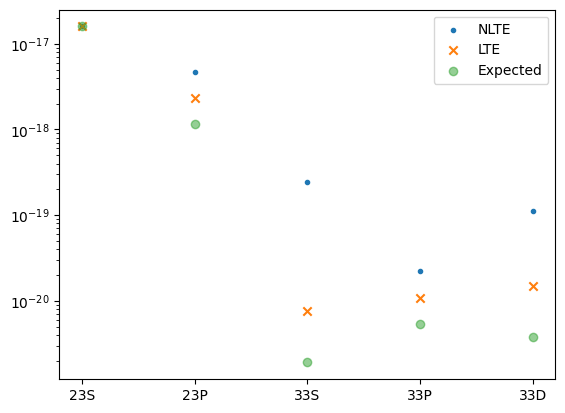

In [51]:
import networkx as nx


states = NLTE.NLTE_model.States()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(T_phot=4400.0), states=states)
rad_process = nlte_solver.processes[1]
nlte_solver.processes = [rad_process]
idx_of = lambda x: nlte_solver.states.all_names.index(x)
min_rate = 0.01
max_rate = 1e2
max_width = 3
for a,b in [("33S", "33P"), ("33P", "33D")]:
    idx_a = idx_of(a)
    idx_b = idx_of(b)
    rad_process.A[idx_a, idx_b] = 0
    rad_process.A[idx_b, idx_a] = 0
    rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
    rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
    rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
    rad_process.stimulated_emission_rate[idx_b, idx_a] = 0

y = nlte_solver.solve(1e6)[1][:,-1]
ortho_filter = np.array([name[-2] == "3" for name in states.all_names])
plt.scatter(np.array(states.all_names)[ortho_filter], y[ortho_filter], marker=".", label = f"NLTE");

environment = nlte_solver.environment
bolzman = states.multiplicities * np.exp(-states.energies / (const.k_B * environment.T_phot * u.K))
lte_pop = bolzman[ortho_filter[:-2]] /bolzman[1]  * y[1]
plt.scatter(np.array(states.all_names)[ortho_filter], lte_pop, marker="x", label = f"LTE");
plt.scatter(np.array(states.all_names)[ortho_filter], lte_pop * [1, 1/2, 1/4, 1/2, 1/4], marker="o", alpha=0.5, label = f"Expected");
print(states.energies[ortho_filter[:-2]])
plt.legend()
plt.yscale("log")

# Test of collisional solver

In [13]:
states = NLTE.NLTE_model.States.read_states()
nlte_solver = NLTE.NLTE_model.NLTESolver(NLTE.NLTE_model.Environment(), states=states)
nlte_solver.environment.n_e=1e30
y = nlte_solver.solve(1e6)[1][:-2,-1]
#print("High density limit correct: ", 0.5 > pop_frac(nlte_solver.solve(1e6)[1][[i23S, i23P],-1]))
p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * nlte_solver.environment.T_electrons*u.K))
pop = p_i / sum(p_i) * sum(y)
print("High density limit correct: ", np.allclose(pop_frac(y), pop_frac(pop)))

   Configuration Term  J  g  Level (eV)  Uncertainty (eV)          Reference  \
0            1s2   1S  0  1    0.000000      1.500000e-07             L22715   
1          1s.2s   3S  1  3   19.819615      5.000000e-09  L22715c200,L20736   
2          1s.2s   1S  0  1   20.615775      8.000000e-09  L22715c200,L20736   
3          1s.2p  3P*  2  5   20.964087      3.000000e-09  L22715c200,L20736   
4          1s.2p  3P*  1  3   20.964096      3.000000e-09  L22715c200,L20736   
5          1s.2p  3P*  0  1   20.964219      3.000000e-09  L22715c200,L20736   
6          1s.2p  1P*  1  3   21.218023      1.600000e-09  L22715c200,L20736   
7          1s.3s   3S  1  3   22.718466      8.000000e-09         L22715c200   
8          1s.3s   1S  0  1   22.920317      4.000000e-09         L22715c200   
9          1s.3p  3P*  2  5   23.007073      4.000000e-11         L22715c200   
10         1s.3p  3P*  1  3   23.007076      4.000000e-10         L22715c200   
11         1s.3p  3P*  0  1   23.007109 